# Sieci Reukrencyjne

## I. Przygotowanie

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda") 
device

device(type='cuda')

## II. Przygotowanie danych

Tworzony jest sztuczny zbiór danych - w formie szeregu czasowego.

In [3]:
indices = np.arange(0,50, 0.02)
synthetic_data = (np.sin(indices*3)+indices/10 + (indices/10)**2 + np.sin(indices*10)) #/ np.exp(indices/20)

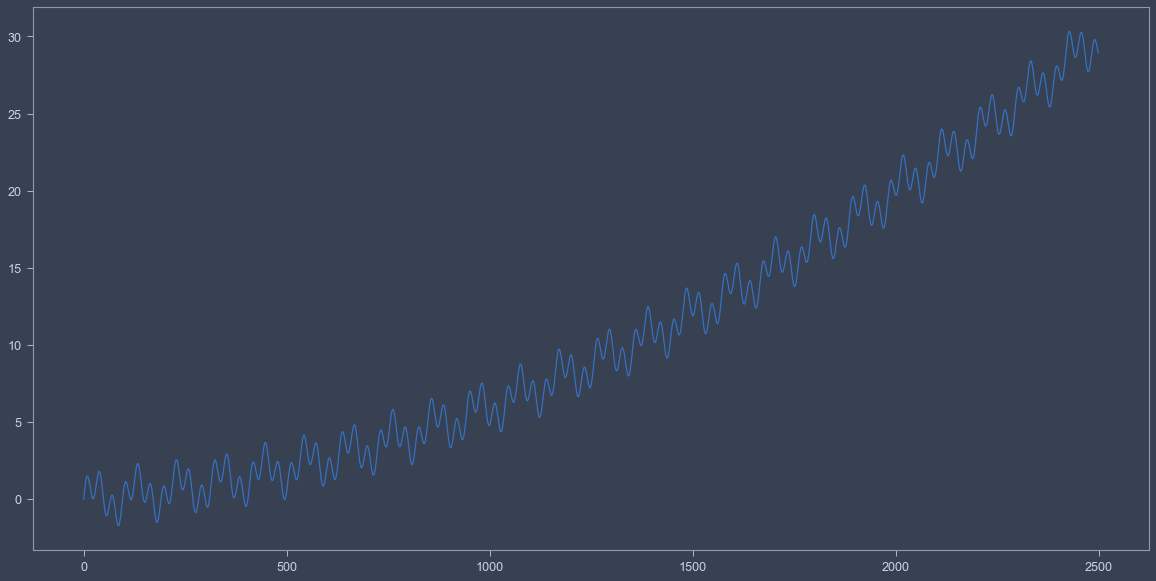

In [4]:
plt.figure(figsize=[20,10])
plt.plot(synthetic_data)
plt.show()

Normalizacja danych.

In [5]:
min_value = synthetic_data.min()
max_value = synthetic_data.max()

Dane w formie sekwencji o stałej długości - chcemy się zająć przewidzeniem kolejnego kroku tej sekwencji. Np tutaj mamy 150 dni.

In [6]:
data_seq = []
data_targets = []
sequence_len = 150
for i in range(len(synthetic_data)-sequence_len-1):
    data_seq.append(torch.from_numpy(synthetic_data[i:i+sequence_len]))
    data_targets.append(synthetic_data[i+sequence_len+1])

Normalizacja danych, podział na zbiory.

In [7]:
data = (torch.stack(data_seq).float()-min_value)/max_value
data_targets = (torch.Tensor(data_targets).float()-min_value)/max_value
train_indices = np.random.rand(len(data_seq))>0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_data, test_targets = data[test_indices], data_targets[test_indices]

In [28]:
print(data)

tensor([[0.0559, 0.0645, 0.0729,  ..., 0.0575, 0.0537, 0.0511],
        [0.0645, 0.0729, 0.0807,  ..., 0.0537, 0.0511, 0.0498],
        [0.0729, 0.0807, 0.0877,  ..., 0.0511, 0.0498, 0.0498],
        ...,
        [0.9260, 0.9226, 0.9205,  ..., 1.0351, 1.0321, 1.0283],
        [0.9226, 0.9205, 0.9196,  ..., 1.0321, 1.0283, 1.0239],
        [0.9205, 0.9196, 0.9200,  ..., 1.0283, 1.0239, 1.0193]])


In [31]:
print(data.size())

torch.Size([2349, 150])


## III. Pomysł pierwszy na przewidzenie - bez sieci rekurencyjnych prosty
Wykorzystajmy proste warstwy fully-connected, aby stworzyć model przewidujący kolejną warstość sekwencji.
Na wejściu wchodzi wektor stanowiący całe okno czasowe i wyprowadzane jest wyjście jako przewidzenie.

#### Stworzenie modelu

In [8]:
class SimpleRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
    
model = SimpleRegressor(sequence_len,5,1).to(device)
model

SimpleRegressor(
  (linear1): Linear(in_features=150, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

#### Trenowanie modelu

In [10]:
model.train() 

# Training loop
for epoch in range(41):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0295
Epoch: 10, loss: 4.55e-05
Epoch: 20, loss: 6.18e-05
Epoch: 30, loss: 3.4e-05
Epoch: 40, loss: 0.000801


#### Ewaluacja modelu

In [11]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze()-test_targets.to(device)).mean())

tensor(0.0085, device='cuda:0')


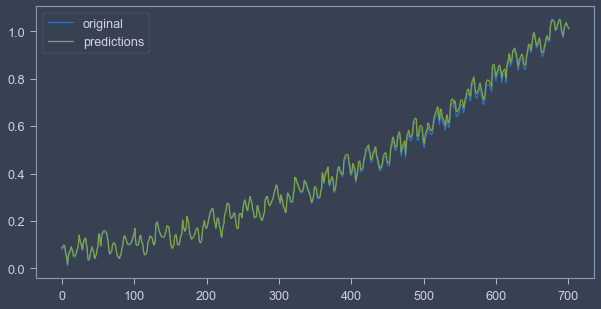

In [12]:
plt.figure(figsize=[10,5])
plt.plot(test_targets.numpy(), label = 'original')
plt.plot(test_preds.cpu().numpy(), label = 'predictions')
plt.legend()
plt.show()

#### Wnioski
Wydaje się, że jest wszystko dobrze.  Jest z tym jednak problem - docelowo chcielibyśmy, żeby długość sekwencji była różna.
Dodatkowo, do zbioru testowego trafiają losowe punkty - wszystkie punkty dookoła punktu testowego będą w zbiorze treningowym, więc model najprościej będzie interpolować wartosci pomiędzy.

## IV. Pomysł bez RNN - drugi
Pomysły na poprawę:
+ Chcemy wyciąć większe fragmenty, żeby sieci trudniej było interpolować te fragmenty.
+ <b>Lub chcemy przyciąć szereg w pewnym miejsciu i zobaczyć co będzie predykowane dalej - dużo trudniejsze zadanie - trzeba modelować coś czego sieć nie widziała nigdy na oczy - wykonamy to</b>.

#### Nowy podział

In [23]:
train_split = int(len(data)*0.7)    # taking first 70% of series data as train data
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

#### Stworzenie modelu

In [24]:
model = SimpleRegressor(sequence_len,5,1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()
model

SimpleRegressor(
  (linear1): Linear(in_features=150, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

#### Trening

In [25]:
# Training loop
for epoch in range(41):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00124
Epoch: 10, loss: 6.72e-05
Epoch: 20, loss: 6.95e-05
Epoch: 30, loss: 8.97e-05
Epoch: 40, loss: 0.000133


#### Ewaluacja

In [26]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze()-test_targets.to(device)).mean())

tensor(0.1168, device='cuda:0')


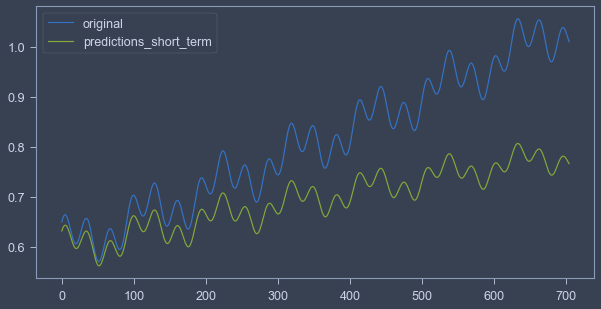

In [27]:
plt.figure(figsize=[10,5])
plt.plot(test_targets.numpy(), label = 'original')
plt.plot(test_preds.cpu().numpy(), label = 'predictions_short_term')
plt.legend()
plt.show()

Zauważmy, że im dalej jesteśmy od początku tym gorzej (bo dalej są dużo większe wartości, na których model sie nie zna.

## V. Sieci rekurencyjne
<img src="https://miro.medium.com/max/1400/1*SKGAqkVVzT6co-sZ29ze-g.png" alt="Witam" style="width: 100px; border: 2px solid black;">

Chcemy modelować sekwencje wejściowe o dowolnej długości.
W sieci rekurencyjnej wyjście sieci z poprzedniego punktu czasowego trafia na wejście sieci z poprzedniego punktu czasowego. Mamy tutaj dwa wyjścia, gdzie jedno z nich zawija się i trafia do siebie w kolejnym kroku czasowym.

### V.1. Sieć o oddzielnych dwóch wyjściach

#### Model sieci
Stosujemy sieć, która wyprowadza dwa wyjścia - stan wewnętrzny oraz wyjście naturalne. Na każde z tych wyjść mamy oddzielną warstwę liniową.

In [35]:
class RecurrentRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, num_state):
        # num inputs = size of input x (U)
        # num state = size of state h (V)
        # num hidden = size of hidden processing layer
        # num outputs = size of output (W)
        super().__init__()
        self.linear1 = nn.Linear(num_inputs + num_state, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear_out = nn.Linear(num_hidden, num_outputs)
        self.linear_state = nn.Linear(num_hidden, num_state)

    def forward(self, x, state):
        x = torch.cat([x, state],1)     # concatenating ht with xt
        x = self.linear1(x)
        x = self.act_fn(x)
        # separate layers for output and state
        out = self.linear_out(x)
        state = self.linear_state(x)
        return out, state
    
model = RecurrentRegressor(1,5,1,5).to(device)
model

RecurrentRegressor(
  (linear1): Linear(in_features=6, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (linear_state): Linear(in_features=5, out_features=5, bias=True)
)

#### Trening

In [36]:
x, targ = next(iter(train_loader))
print(x.size(1))

150


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()
STATE_SIZE = 5
SEQUENCE_LENGTH = 150
for epoch in range(41):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)
        loss_total = 0
        state = torch.zeros(len(x),STATE_SIZE).to(device)    # initial state is full of zeros
        optimizer.zero_grad() 
        for i in range(SEQUENCE_LENGTH):                         # for each x_t
            # NOTE: IN THIS EXAMPLE WE ASSUME THAT SEQ_LEN IS CONSTANT, BUT WE CAN GIVE SEQUENCE OF ANY LENGTH
            x_one = x[:, i].unsqueeze(dim=1)
            if i < SEQUENCE_LENGTH -1:                          # we compare x_t with x_t+1 if its not x_T
                target = x[:, i+1]
            else:                                            # if its x_T, we should compare it with target from loader
                target = targets
            preds, state = model(x_one, state)
            preds = preds.squeeze(dim=1)
            loss = loss_fun(preds, target)
            loss_total += loss
        loss_total.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.106
Epoch: 10, loss: 0.014
Epoch: 20, loss: 0.000208
Epoch: 30, loss: 0.000175
Epoch: 40, loss: 0.000149


In [38]:
with torch.no_grad():
    state = torch.zeros(len(test_data),5).to(device)
    test_preds = []
    for i in range(test_data.size(1)):
        x_one = test_data[:,i].unsqueeze(1).to(device)
        preds, state = model(x_one, state)
    test_preds.append(preds)
    print(torch.abs((torch.cat(test_preds).squeeze() - test_targets.to(device))).mean())

tensor(0.0513, device='cuda:0')


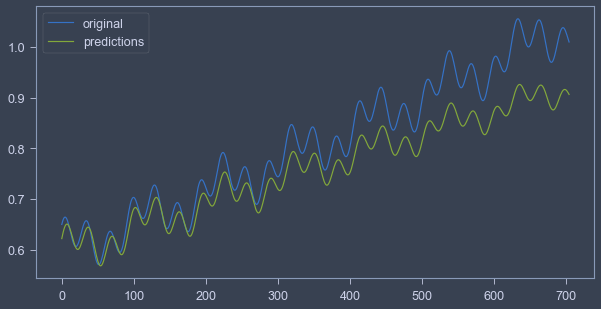

In [39]:
plt.figure(figsize=[10,5])
plt.plot(test_targets, label = 'original')
plt.plot(torch.cat(test_preds).squeeze().cpu().numpy(), label = 'predictions')
plt.legend()
plt.show()

Wyszło troszkę lepiej niż poprzednio, ale plus jest taki, że można podawać sekwencje dowolnej długości.

### V.2. Sieci rekurencyjne w PyTorch

#### Moduł RNN
Jest to podstawowy moduł sieci rekurencyjnej.
Elementy:
- input_size = wielkosc co wkladamy jako wejscie do predykcji w RNN,
- hidden_size = rozmiar wyjscia i rozmiar stanu ktory przekazujemy do kolejnej sieci,
- liczba warstw = Pytorch optymalizuje liczenie tego więc warto tutaj to zrobić,
- batch first = False - jest domyślnie, w RNN przed BATCH_SIZE jest długość sekwencji, dopiero potem mamy wielkość batcha, a na koncu wielkosc wejscia

In [40]:
batch_size = 2
input_size = 3
hidden_size = 4
num_layers = 2
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=False) #batch_first=False is default!!
rnn

RNN(3, 4, num_layers=2)

In [41]:
with torch.no_grad():
    sequence_len = 5
    x = torch.randn(sequence_len, batch_size, input_size)
    h0 = torch.randn(num_layers, batch_size, hidden_size)
    output, hn = rnn(x, h0)             # dostajemy output i ostatni stan
output

tensor([[[ 0.4816, -0.3530,  0.0320, -0.0103],
         [-0.4501, -0.3687,  0.0104,  0.1042]],

        [[ 0.4511, -0.3738,  0.0974, -0.0918],
         [ 0.4287, -0.6084, -0.1527,  0.2847]],

        [[ 0.2732, -0.3804,  0.1606,  0.0163],
         [ 0.0552, -0.2638, -0.2822,  0.0421]],

        [[ 0.4811, -0.4722,  0.2421, -0.3319],
         [ 0.5832, -0.6150,  0.1731, -0.3608]],

        [[-0.0702, -0.2516, -0.1207,  0.2668],
         [ 0.0096, -0.2465, -0.3985,  0.1583]]])

In [42]:
output.size(
)                   # 5 to dlugosc sekwencji wyjsciowej (takiej jak wejsciowa) - wyjscie dla kazdego z wejsc, 2 to liczba batchy, 4 to dlugosc wektora wyjsciowego

torch.Size([5, 2, 4])

In [43]:
output[-1] # jesli chcemy ostatnią predykcję

tensor([[-0.0702, -0.2516, -0.1207,  0.2668],
        [ 0.0096, -0.2465, -0.3985,  0.1583]])

In [44]:
hn

tensor([[[-0.5037, -0.1481, -0.0496,  0.5624],
         [ 0.0416,  0.3822,  0.2596,  0.4760]],

        [[-0.0702, -0.2516, -0.1207,  0.2668],
         [ 0.0096, -0.2465, -0.3985,  0.1583]]])

In [46]:
hn.size()   # 2 to liczba warstw, 2 to rozmiar batcha, 4 to rozmiar wektora stanu

torch.Size([2, 2, 4])

Zauważmy, że ostatnia predykcja tutaj jest taka sama jak stan wychodzący z ostatniej (drugiej) warstwy.

#### Nowy model sieci

In [49]:
class RNNRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.fc = nn.Linear(hidden_size, out_size)      # output of rnn is interpreted by other fully-connected layer
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)  # transpose - such change of dimension that sequence size is first
        all_outputs, hidden = self.rnn(x, hidden)
        out = all_outputs[-1]       # only last prediction is input for fc layer
        x = self.fc(out)
        return x, hidden
    
model = RNNRegressor(1,5,2,1).to(device)
model

RNNRegressor(
  (rnn): RNN(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

#### Nauka modelu

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

for epoch in range(41):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x, hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0354
Epoch: 10, loss: 0.000358
Epoch: 20, loss: 0.000264
Epoch: 30, loss: 0.00019
Epoch: 40, loss: 0.00015


#### Ewaluacja

In [51]:
with torch.no_grad():
    hidden = model.init_hidden(len(test_data)).to(device)                       # inicjalizacja stanu sieci zerami (na początku trzeba podać coś bezsensownego)
    test_preds, _ = model(test_data.to(device).unsqueeze(2),hidden)
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.0771, device='cuda:0')


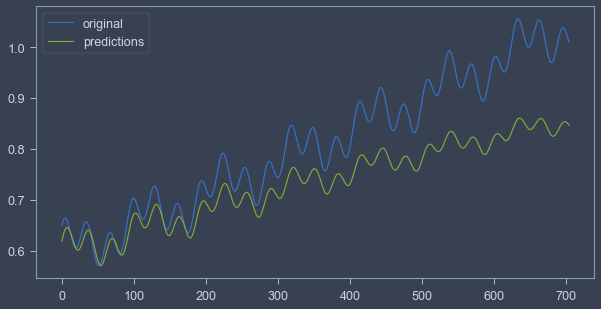

In [52]:
plt.figure(figsize=[10,5])
plt.plot(test_targets, label = 'original')
plt.plot(test_preds.squeeze().cpu().numpy(), label = 'predictions')
plt.legend()
plt.show()

## VI. Rozdzielenie krótkiej i długiej pamięci - LSTM
+ Poniżej zamieszczona została pojedyncza komórka LSTM.
+ W LSTM skomplikowano wszystko - rozdzielono na dwie części stan przekazywany w sieci i w odpowiedni sposób włączono to, co przyszło poprzednio, z aktualnym wejściem i przekazano dalej.
+ Wejście przepuszczamy przez bramkę zapominającą - jej cel to stwierdzenie co chcemy zapomnieć i nie brać pod uwagę w kolejnym stanie. Przemnazamy go przez poprzedni stan i dostajemy to co poprzednio ale usunięte o to co jest do zapomnienia.
+ Kolejna bramka składa się z dwóch mini sieci - tworzy ona wiedzę.
+ Ostatnia mini sieć - bramka wyjściowa - na podstawie wejścia połączonego z poprzednim stanem, decydujemy co chcemy zwrócić, biorąc pod uwagę nasz poprzedni stan w poprzednim czasie.

![LSTM](https://cdn-images-1.medium.com/max/1000/1*Ht2-sUJHi65wDwnR276k3A.png)

#### Przejście RNN -> LSTM
Jedyne co zamieniamy w PyTorch to RNN->LSTM. Tak więc będziemy inicjować teraz dwa stany - hidden state i cell state.

In [63]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
lstm = nn.LSTM(input_size = 1, hidden_size=hidden_size, num_layers=num_layers)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, hidden_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))       # lstm needs such tuple

In [64]:
print(output.size())
output

torch.Size([5, 3, 2])


tensor([[[ 0.0387,  0.1270],
         [-0.0087, -0.0830],
         [-0.0838,  0.3105]],

        [[-0.0572,  0.1169],
         [-0.0680,  0.0231],
         [-0.1560,  0.3228]],

        [[-0.1731,  0.1557],
         [-0.1627,  0.0822],
         [-0.1168,  0.2016]],

        [[-0.2245,  0.1556],
         [-0.1225,  0.1002],
         [-0.0596,  0.1581]],

        [[-0.2462,  0.1590],
         [-0.1745,  0.1508],
         [-0.1951,  0.3449]]], grad_fn=<StackBackward>)

In [65]:
print(hn)
print(cn)

tensor([[[-0.2462,  0.1590],
         [-0.1745,  0.1508],
         [-0.1951,  0.3449]]], grad_fn=<StackBackward>)
tensor([[[-0.9632,  0.4291],
         [-0.7129,  0.4536],
         [-0.6618,  1.0816]]], grad_fn=<StackBackward>)


#### Model

In [66]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):          # initializations
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden_state, cell_state        # returning tuple
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)      # all time we are passing hidden as tuple
        out = all_outputs[-1]       # We are interested only on the last output
        x = self.fc(out)
        return x, hidden
    
model = LSTMRegressor(1,20,2,1).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 20, num_layers=2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

#### Uczenie

In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden_state, cell_state = model.init_hidden(x.size(0))
        hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
        preds, last_hidden = model(x, (hidden_state, cell_state))
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00827
Epoch: 10, loss: 0.0011
Epoch: 20, loss: 0.000672
Epoch: 30, loss: 0.00049
Epoch: 40, loss: 0.000325
Epoch: 50, loss: 0.000107
Epoch: 60, loss: 3.78e-05
Epoch: 70, loss: 1.64e-05
Epoch: 80, loss: 1.42e-05
Epoch: 90, loss: 1.07e-05
Epoch: 100, loss: 5.77e-06


In [68]:
with torch.no_grad():
    hidden_state, cell_state = model.init_hidden(test_data.size(0))
    hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
    test_preds, _ = model(test_data.to(device).unsqueeze(2),(hidden_state, cell_state))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean().item())

0.031115323305130005


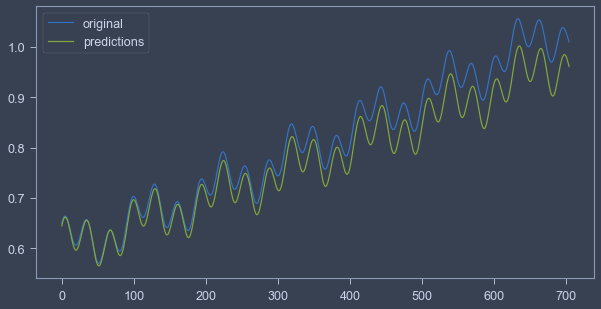

In [69]:
plt.figure(figsize=[10,5])
plt.plot(test_targets, label = 'original')
plt.plot(test_preds.squeeze().cpu().numpy(), label = 'predictions')
plt.legend()
plt.show()

Mamy naprawdę niezłe predykcje, gdy próbujemy przewidzieć następne wartości w oparciu o 150 wcześniejszych, poprawnych wartości.

Ale jakby to działało jakbyśmy przewidywali wartości na kilka dni do przodu?

### VI.1. Predykcje w oparciu o poprzednie predykcje.

In [70]:
with torch.no_grad():
    hidden_state, cell_state = model.init_hidden(1) # no batches
    hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
    hidden = (hidden_state, cell_state)
    x_one = test_targets[0:150].unsqueeze(1).to(device)          # at start we take first 150 values
    preds = []
    for i in range(len(test_targets)):
        pred, hidden = model(x_one.unsqueeze(0), hidden)
        x_one = torch.cat([x_one[1:], pred])
        preds.append(pred.item())

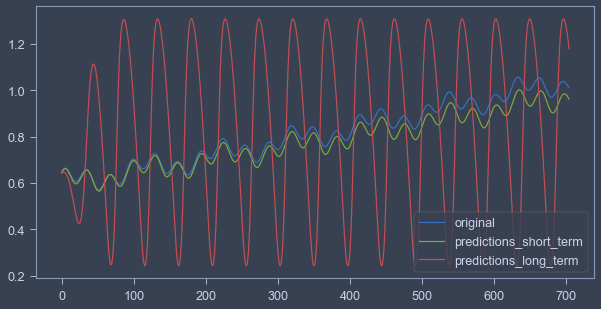

In [71]:
plt.figure(figsize=[10,5])
plt.plot(test_targets, label = 'original')
plt.plot(test_preds.squeeze().cpu().numpy(), label = 'predictions_short_term')
plt.plot(preds, label = 'predictions_long_term')
plt.legend()
plt.show()

Sieci rekurencyjne patrzące w przyszłość nie działają najlepiej, jeśli je nauczymy na poprawnych.

### VI.2. Predykcja sequence -> sequence
Chcemy wykorzystać wiedzę o jednej sekwencji, aby móc wyznaczać wartości dla drugiej sekwencji

In [72]:
stock_price = pd.read_csv("data/all_stocks_5yr.csv")

In [73]:
mastercard_stock = stock_price[stock_price.Name=="MA"].open.values
visa_stock = stock_price[stock_price.Name=="V"].open.values

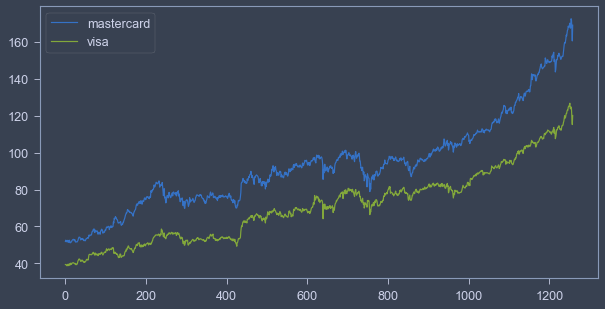

In [74]:
plt.figure(figsize=[10,5])
plt.plot(mastercard_stock, label = 'mastercard')
plt.plot(visa_stock, label = 'visa')
plt.legend()
plt.show()

In [75]:
m_min_value = mastercard_stock.min()
m_max_value = mastercard_stock.max()
v_min_value = visa_stock.min()
v_max_value = visa_stock.max()

#### Przygotowanie zbiorów
Mamy sekwencję długości 50 i przewidujemy jedną na podstawie drugiej.

In [76]:
data_seq = []
data_targets = []
sequence_len = 50
for i in range(len(mastercard_stock)-sequence_len):
    data_seq.append(torch.from_numpy(mastercard_stock[i:i+sequence_len]))               # inputs will be mastercard stocks
    data_targets.append(torch.from_numpy(visa_stock[i:i+sequence_len]))                 # outputs will be visa stocks

# normalizations
data = (torch.stack(data_seq).float()-m_min_value)/m_max_value
data_targets = (torch.stack(data_targets).float()-v_min_value)/v_max_value    

train_split = int(len(data)*0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

Problem - interesuje nas na wyjściu cała sekwencja, nie tylko jej ostatni element - chcemy wziąć wszystkie wyjścia, które mamy (we wszystkich momentach czasowych) i wszystkie je przeprocesować przez warstwę liniową by zmienił się nasz wektor o rozmiarze hidden_size w wartość przewidywanej sekwencji (o rozmiarze 1).
Jest do tego specjalna funkcjonalność w PyTorch - projection - dodatkowa liniowa warstwa aplikowana na wyjściu LSTM, która zmienia wyjście z hidden_size na projection_size.

Przykład:

In [84]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
projection_size = 1

lstm = nn.LSTM(input_size = 1, hidden_size=hidden_size, num_layers=num_layers, proj_size=projection_size)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, projection_size)                     # od teraz hidden ma rozmiar wielkosci projection size
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)                     # a cell state ma rozmair hidden size
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

In [85]:
output

tensor([[[-0.0731],
         [ 0.0238],
         [ 0.0257]],

        [[-0.1357],
         [-0.0436],
         [ 0.0546]],

        [[-0.0875],
         [-0.1151],
         [-0.0587]],

        [[ 0.0036],
         [-0.1514],
         [ 0.0126]],

        [[-0.0817],
         [-0.1679],
         [-0.0388]]], grad_fn=<StackBackward>)

In [86]:
output.size()   # widac ze 2 elementowy hidden_size zmienił się w coś innego

torch.Size([5, 3, 1])

#### Model

In [87]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size=out_size)
        
    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.num_layers, batch_size, self.proj_size)
        cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden_state, cell_state
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1,50,2,1).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 50, proj_size=1, num_layers=2)
)

#### Nauka

In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(2)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0178
Epoch: 10, loss: 0.0175
Epoch: 20, loss: 0.00446
Epoch: 30, loss: 0.00372
Epoch: 40, loss: 0.00355
Epoch: 50, loss: 0.00345
Epoch: 60, loss: 0.00337
Epoch: 70, loss: 0.00329
Epoch: 80, loss: 0.00322
Epoch: 90, loss: 0.00316
Epoch: 100, loss: 0.0031


In [94]:
with torch.no_grad():
    selected_test_targets = []
    preds = []
    for i in range(0,len(test_targets),sequence_len):
        hidden_state, cell_state = model.init_hidden(1)
        hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
        selected_test_targets.append(test_targets[i])
        pred, (hidden_state, cell_state) = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden_state, cell_state))
        preds.append(pred.squeeze())

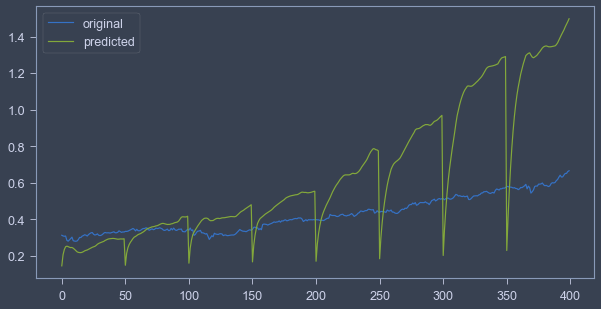

In [95]:
plt.figure(figsize=[10,5])
plt.plot(torch.cat(selected_test_targets).cpu().numpy(), label = 'original')
plt.plot(torch.cat(preds).cpu().numpy(), label = 'predicted')
plt.legend()
plt.show()

Problem - co 50 wyraz ma dziwne wartości - wynika to z inicjowania hidden_state zerami co dlugość sekwencji, należy więc to poprawić:

In [96]:
with torch.no_grad():
    selected_test_targets2 = []
    preds2 = []
    hidden_state, cell_state = model.init_hidden(1)                    # hidden state mozna zainicjalizowac na poczatku raz
    hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
    for i in range(0,len(test_targets),sequence_len):
        selected_test_targets2.append(test_targets[i])
        pred, (hidden_state, cell_state) = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden_state, cell_state))
        preds2.append(pred.squeeze())

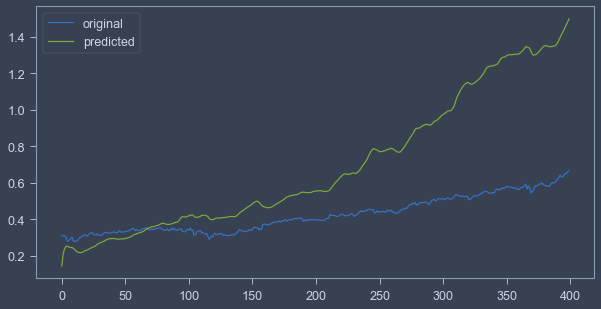

In [97]:
plt.figure(figsize=[10,5])
plt.plot(torch.cat(selected_test_targets2).cpu().numpy(), label = 'original')
plt.plot(torch.cat(preds2).cpu().numpy(), label = 'predicted')
plt.legend()
plt.show()

### VI.3. Klasyfikacja serii

#### Zbiór danych
Zbiór sekwencji ruchów osoby mówiącej językiem migowym.

In [98]:
libras = pd.read_csv("data/movement_libras.data",header=None)

In [103]:
libras.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.79691,0.38194,0.79691,0.37731,0.79884,0.37731,0.79497,0.37731,0.77563,0.35417,...,0.51389,0.39845,0.42593,0.47389,0.36111,0.55899,0.31250,0.63830,0.29398,1
1,0.67892,0.27315,0.68085,0.27315,0.68085,0.27315,0.68085,0.27315,0.67892,0.26852,...,0.57407,0.17795,0.63657,0.17215,0.67361,0.17021,0.69213,0.17215,0.69213,1
2,0.72147,0.23611,0.72340,0.23611,0.72340,0.23611,0.72340,0.23611,0.72340,0.23611,...,0.30556,0.59768,0.25926,0.67118,0.25231,0.73501,0.26620,0.78143,0.27778,1
3,0.56480,0.32407,0.56286,0.32407,0.56093,0.32407,0.55899,0.32407,0.55899,0.32407,...,0.49074,0.26306,0.42361,0.33269,0.34722,0.41006,0.28009,0.49130,0.24306,1
4,0.67118,0.38426,0.67118,0.38657,0.67311,0.38657,0.67311,0.38426,0.67311,0.37963,...,0.76389,0.44101,0.64120,0.45068,0.54167,0.47776,0.44213,0.53191,0.34259,1


In [104]:
classes = libras[90].values
data = libras.values[:,:-1]

#### Podział na konkretne zbiory

In [105]:
data = torch.from_numpy(data).float()
data_targets = torch.from_numpy(classes).long()

train_indices = np.random.rand(len(data))>0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32)
test_data, test_targets = data[test_indices], data_targets[test_indices]

#### Model

In [109]:
class LSTM_Series_Classificator(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bideractional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bideractional:
            self.bideractional = 2
        else:
            self.bideractional = 1

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bideractional)
        self.fc_classificator = nn.Linear(in_features=90*self.bideractional*hidden_size, out_features=out_size)

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.num_layers*self.bideractional, batch_size, self.hidden_size)
        cell_state = torch.zeros(self.num_layers*self.bideractional, batch_size, self.hidden_size)
        return hidden_state, cell_state

    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        out = torch.flatten(all_outputs,1)
        out = self.fc_classificator(out)
        return out, hidden

model = LSTM_Series_Classificator(1,10,2,16, True).to(device)
model

LSTM_Series_Classificator(
  (lstm): LSTM(1, 10, num_layers=2, bidirectional=True)
  (fc_classificator): Linear(in_features=1800, out_features=16, bias=True)
)

#### Uczenie

In [112]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

for epoch in range(1001):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden_state, cell_state = model.init_hidden(x.size(0))
        hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
        preds, _ = model(x, (hidden_state,cell_state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 1.33
Epoch: 10, loss: 0.282
Epoch: 20, loss: 0.242
Epoch: 30, loss: 0.211
Epoch: 40, loss: 0.267
Epoch: 50, loss: 0.214
Epoch: 60, loss: 0.236
Epoch: 70, loss: 0.166
Epoch: 80, loss: 0.169
Epoch: 90, loss: 0.29
Epoch: 100, loss: 0.144
Epoch: 110, loss: 0.224
Epoch: 120, loss: 0.158
Epoch: 130, loss: 0.0917
Epoch: 140, loss: 0.154
Epoch: 150, loss: 0.186
Epoch: 160, loss: 0.293
Epoch: 170, loss: 0.0944
Epoch: 180, loss: 0.0714
Epoch: 190, loss: 0.0679
Epoch: 200, loss: 0.062
Epoch: 210, loss: 0.068
Epoch: 220, loss: 0.0387
Epoch: 230, loss: 0.0384
Epoch: 240, loss: 0.082
Epoch: 250, loss: 0.411
Epoch: 260, loss: 0.386
Epoch: 270, loss: 0.18
Epoch: 280, loss: 0.147
Epoch: 290, loss: 1.43
Epoch: 300, loss: 1.06
Epoch: 310, loss: 0.893
Epoch: 320, loss: 0.771
Epoch: 330, loss: 0.65
Epoch: 340, loss: 0.542
Epoch: 350, loss: 0.443
Epoch: 360, loss: 0.356
Epoch: 370, loss: 0.302
Epoch: 380, loss: 0.253
Epoch: 390, loss: 0.214
Epoch: 400, loss: 0.185
Epoch: 410, loss: 0.22
Epoc

#### Walidacja

In [113]:
with torch.no_grad():
    hidden_state, cell_state = model.init_hidden(len(test_data))
    hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
    preds, _ = model(test_data.to(device).unsqueeze(2), (hidden_state, cell_state))
print(f"Accuracy: {(torch.argmax(preds,1).cpu()==test_targets).sum().item()/len(test_targets):.3}")

Accuracy: 0.702
